New notebook to look at computing temporal and spatial averages of GRSST over a National Marine Sanctuary.
Below are the various python modules that are needed to run the code.

In [1]:
%matplotlib inline
import numpy as np
import datetime
import time
import netCDF4
from pydap.client import open_url
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.mlab as ml
from mpl_toolkits.basemap import Basemap
import pyproj
from shapely.geometry import Polygon,Point
import pdb
from IPython import display
import math

Set up the URL to the data we want to work with.  GRSST appears to have had two different data sets.

In [2]:
#urltemp='http://coastwatch.pfeg.noaa.gov/erddap/griddap/jplG1SST'
urltemp='http://coastwatch.pfeg.noaa.gov/erddap/griddap/jplMURSST41'
# variables
# longitude
# latitude
# sst

In [3]:
urltemp2='http://coastwatch.pfeg.noaa.gov/erddap/griddap/erdGRssta1day'
# variables
# sst
# longitude
# latitude

Define the variable to use (this allows the user to set up for other variables).

In [4]:
var='sst'

In [5]:
if var=='sst':
    urltouse=urltemp
    #varname='SST'
    varname='analysed_sst'

Now we need to refine the search for the region of interest.  The big problem is to find the boundary of the sanctuary.
Unfortunately this is done by reading a kml into matlab so that we can get the latitude and longitudes that we need.
I've made files for the west coast sanctuaries.

In [6]:
# Other sanctuary boundary files
# cordel_bank.mat # cordel bank sanctuary boundary (simple boundary)
# cordel=scipy.io.loadmat('c:\mbns_file\other_sanctuarys\cordel_bank.mat')
# mlat=cordel
# channel_island_boundarys.mat # channel island sanctuary lots of boundaries
# farallon.mat # gulf of farallong island sanctuary boundary (simple boundary)
# olympic_nms.mat # olympic national marine sanctuary boundary (has a hole in it, not sure what this is)

The file below the boundary used by the Monterey Bay National Marine Sactuary for their reports.

In [7]:
mbns_outer=scipy.io.loadmat('c:\mbns_file\mbnms_offshore.mat')

In [8]:
mlat=mbns_outer['lat']
mlong=mbns_outer['long']
lat=np.transpose(mlat)
long=np.transpose(mlong)

The line below is for the whole Monterey Bay National Marine Sanctuary.

In [9]:
#mbns_data=scipy.io.loadmat('c:\mbns_file\mbns_outline.mat')

In [10]:
#lat=mbns_data['lat']
#long=mbns_data['long']

Create projection information so that we can find pixel points within the MBNMS polygon

In [11]:
wgs84=pyproj.Proj(init='EPSG:4326')

In [12]:
npmerc=pyproj.Proj("+proj=merc +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

This section loads the Davidson seamount sanctuary part.

In [13]:
ff=open('c:\mbns_file\squarepart.dat')

In [14]:
davidlon=[]
davidlat=[]
for line in ff:
    line=line.split(',')
    davidlon.append(line[0])
    davidlat.append(line[1])

In [15]:
ff.close()

Okay, we now have outlines for the Monterey Bay National Sanctuary (MBNS), now we will need to figure out
how to write the complete URL for getting data.  We also need to set up times to step through of the data.
The times appear to have some at 12:00 and some at 00:00.  The first part of the record is set at noon (2010-06-09T12:00:00 and
 shifts to 00:00 on day 2011-05-17).

In [16]:
currtime=datetime.datetime.now()
currentordinal=datetime.date.toordinal(currtime)
start=datetime.datetime(2010,6,9,12,0,0)
firstordinal=datetime.date.toordinal(start)
trange=np.arange(firstordinal,currentordinal-1)

Check that what the url is that we are actually using.

In [17]:
print urltouse

http://coastwatch.pfeg.noaa.gov/erddap/griddap/jplMURSST41


Set up some empty arrays for the data.  Then get the time, latitude and longitude of each pixel.  Convert time to ordinal numbers for manipulation.


In [18]:
mysumarea=[]
mysum_mbnms=[]
mysumsq=[]
mybigts=[]
ic=0
mytimeseries=[]
datapointer=open_url(urltouse)
data=datapointer[varname]
timevec=datapointer['time']
lats=datapointer['latitude']
longs=datapointer['longitude']
time=timevec[:]
time=time/24/60/60
offset=datetime.datetime(1970,1,1)
offset=datetime.date.toordinal(offset)
# convert to ordinal numbers so we can loop
time=time+offset
time=np.floor(time)


Now that we have the image latitudes and longitudes we can create a mask for the image

In [19]:
polyx,polyy=pyproj.transform(wgs84,npmerc,long,lat)

Find the index of latitude and longitude of a grid containing the MBNMS

In [20]:
glat=lats[:]
glon=longs[:]
maxlat=np.max(np.ceil(lat))
minlat=np.min(np.floor(lat))
maxlon=np.max(np.ceil(long*10))/10
minlon=np.min(np.floor(long*10))/10
pindexlat=np.where((glat >= minlat)&(glat <= maxlat))
pindexlon=np.where((glon >= minlon)&(glon <= maxlon))

In [21]:
clon=glon

The above limits were determinded from the min and max values of the sanctuary polygon.  This could probably be done using code.  Added code so it is done with code.  

In [22]:
pindexlat=pindexlat[0]
pindexlon=pindexlon[0]
glat=glat[pindexlat]
glon=glon[pindexlon]

Now we need to create a mesh grid of these points to create the mask of the region

In [23]:
myx,myy=np.meshgrid(glon,glat)
gridx,gridy=pyproj.transform(wgs84,npmerc,myx,myy)

Now to create the actual polygon that shapely will use.  zip is a built in python function

In [24]:
poly_proj=Polygon(zip(polyx[0],polyy[0]))

Create mask array of proper size blanked with zeros

In [25]:
mask=np.zeros_like(myx)
(x,y)=gridx.shape
zlx=x
zly=y

Now to assign values to the mask if it is inside or not

In [26]:
for i in range(x):
    for j in range(y):
        grid_point=Point(gridx[i][j],gridy[i][j])
        if grid_point.within(poly_proj):
            mask[i][j]=1

We need to get the indicies in both the x and y direction so we can subset.  We will loop through times and compute means along with keep growing mean and a time-series of the areal means.

Sst is filled completely but other variables may have gaps and thus need to have an array of values to divide by and not just a single number.

In [27]:
# create arrays for use later size is unknown
mybigarray=[]
myotherbigarray=[]
# find index of array elements over Davidson Seamount.
indexlat=np.where((lats >=float(davidlat[0]))&(lats <= float(davidlat[2])))
indexlong=np.where((longs >= float(davidlon[1]))&(longs <= float(davidlon[0])))
indexlat=indexlat[0]
indexlong=indexlong[0]
plat=lats[:]
plat=plat[indexlat]
plon=longs[:]
plon=plon[indexlong]
mytvec=[]
bmask=mask.astype(bool)
ic=0

Now the big time consuming loop.  This grabs an image at a time.  Limits how much is loaded at a time but
takes quite a lot of time.  

In [28]:
if var=='sst':
    # create arrays to store data for computing anomalies
    mybigarray=[]
    myotherbigarray=[]
    indexlat=np.where((lats >=float(davidlat[0]))&(lats <= float(davidlat[2])))
    indexlong=np.where((longs >= float(davidlon[1]))&(longs <= float(davidlon[0])))
    indexlat=indexlat[0]
    indexlong=indexlong[0]
    plat=lats[:]
    plat=plat[indexlat]
    plon=longs[:]
    plon=plon[indexlong]
    mytvec=[]
    ic=0
    bmask=mask.astype(bool)
    for myt in trange:
        tindex=np.where(myt==time)
        try:
            tindex=tindex[0]
            if len(tindex) > 0:
                i=int(tindex[0])
                if ic==0:
                    datasubset1=data[varname][i,indexlat[0]:indexlat[-1]+1,indexlong[0]:indexlong[-1]+1]
                    datasubset2=data[varname][i,pindexlat[0]:pindexlat[-1]+1,pindexlon[0]:pindexlon[-1]+1]
                    datasubset2=datasubset2[0]
                    datasubset1=datasubset1[0]
                    mybigarray=datasubset2
                    datasubset2=np.squeeze(datasubset2)
                    datasubset2[np.logical_not(bmask)]=0
                    mysum_mbnms=datasubset2
                    mysumarea=np.squeeze(datasubset1)
                    mysumsq=np.squeeze(datasubset1)*np.squeeze(datasubset1)
                    myotherbigarray=datasubset1
                    mytimeseries=np.array([np.mean(mysumarea)])
                    ll=mysum_mbnms > 0
                    mybigts=np.array([np.mean(mysum_mbnms[ll])])
                    mytvec=myt
                    ic=1
                else:
                    datasubset1=data[varname][i,indexlat[0]:indexlat[-1]+1,indexlong[0]:indexlong[-1]+1]
                    datasubset2=data[varname][i,pindexlat[0]:pindexlat[-1]+1,pindexlon[0]:pindexlon[-1]+1]
                    datasubset2=datasubset2[0]
                    datasubset1=datasubset1[0]
                    mybigarray=np.vstack((mybigarray,datasubset2))
                    myotherbigarray=np.vstack((myotherbigarray,datasubset1))
                    datasubset2=np.squeeze(datasubset2)
                    datasubset2[np.logical_not(bmask)]=0
                    ll=datasubset2 > 0
                    lo=datasubset1 > 0
                    mysum_mbnms=mysum_mbnms+datasubset2
                    mysumarea=mysumarea+np.squeeze(datasubset1)
                    mysumsq=mysumsq+np.squeeze(datasubset1)*np.squeeze(datasubset1)
                    x=np.array([np.nanmean(np.squeeze(datasubset1[lo]))])
                    y=np.array([np.nanmean(datasubset2[ll])])
                    mytimeseries=np.append(mytimeseries,x)
                    mybigts=np.append(mybigts,y)
                    mytvec=np.append(mytvec,myt)
                    ic=ic+1
        except:
            print "No time match for "+str(datetime.date.fromordinal(myt))
        

No time match for 2013-09-23
No time match for 2014-09-05


In [29]:
[zlx,zly]=mysum_mbnms.shape
[zpx,zpy]=mysumarea.shape

Save the data incase we need to reload the data and we don't want to load it over the web again.
This can be commented out if we are running as a daily code.

In [30]:
# Need to save data so we don't have to load this everytime...
#
filename='a_test_set_data.nc'
ncfile=netCDF4.Dataset(filename,'w',format='NETCDF3_CLASSIC')
ncfile.createDimension('time',None)
ncfile.createDimension('gridx',zly)
ncfile.createDimension('gridy',zlx)
ncfile.createDimension('pgridx',zpy)
ncfile.createDimension('pgridy',zpx)
ncfile.createDimension('count',1)
setattr(ncfile,'unlimited_dimension','time')
ztime=ncfile.createVariable('time','f8',('time'),fill_value=-99999.0)
zgridx=ncfile.createVariable('gridx','f4',('gridx'),fill_value=-99)
zgridy=ncfile.createVariable('gridy','f4',('gridy'),fill_value=-99)
zpgridx=ncfile.createVariable('pgridx','f4',('pgridx'),fill_value=-99)
zpgridy=ncfile.createVariable('pgridy','f4',('pgridy'),fill_value=-99)
ztimeseries=ncfile.createVariable('mytimeseries','f4',('time'),fill_value=-99)
ztimeseries2=ncfile.createVariable('mytimeseries2','f4',('time'),fill_value=-99)
zsum_mbnms=ncfile.createVariable('mysum_mbnms','f8',('gridy','gridx'),fill_value=-99)
zsumarea=ncfile.createVariable('mysumarea','f8',('pgridy','pgridx'),fill_value=-99)
zbig=ncfile.createVariable('mybigarray','f8',('time','gridy','gridx'),fill_value=-99)
zbig2=ncfile.createVariable('mybigarray2','f8',('time','pgridy','pgridx'),fill_value=-99)

setattr(ncfile,'ic',ic)
ztime[:]=mytvec
zgridx[:]=glon
zgridy[:]=glat
ztimeseries[:]=mytimeseries
zsum_mbnms[:,:]=mysum_mbnms
zbig[:,:,:]=mybigarray
zpgridx[:]=plon
zpgridy[:]=plat
ztimeseries2[:]=mybigts
zsumarea[:,:]=mysumarea
zbig2[:,:,:]=myotherbigarray
ncfile.close()

We now should have a time-series and a cumulative sum (and maybe a cumulative sum of squares?)

In [31]:
filetoload='a_test_set_data.nc'
ncfile=netCDF4.Dataset(filetoload,'r',format='NETCDF3_CLASSIC')
mytimeseries=ncfile.variables['mytimeseries'][:]
mysum_mbnms=ncfile.variables['mysum_mbnms'][:,:]
mybigarray=ncfile.variables['mybigarray'][:,:,:]
glat=ncfile.variables['gridy'][:]
glon=ncfile.variables['gridx'][:]
mytvec=ncfile.variables['time'][:]
plat=ncfile.variables['pgridy'][:]
plon=ncfile.variables['pgridx'][:]
myotherbigarray=ncfile.variables['mybigarray2'][:,:,:]
mybigtx=ncfile.variables['mytimeseries2'][:]
mysumarea=ncfile.variables['mysumarea'][:,:]
ic=ncfile.getncattr('ic')
ncfile.close()

Compute the mean values at each pixel.

In [32]:
if var=='sst':
    #mysumarea=mysumarea/ic
    #mysumsq=mysumsq/ic
    mysum_mbnms=mysum_mbnms/ic
    mysumarea=mysumarea/ic

Configure the plot size.

In [33]:
plt.rcParams['figure.figsize']=[16,20]

Create a map of California with a cylindrical projection and given latitude and longitude limits.

In [34]:
mp=Basemap(llcrnrlon=236.8,llcrnrlat=35,urcrnrlon=239,urcrnrlat=38,resolution='f',projection='cyl')

Make the longitude to range from 0 to 360 instead of -180 to 180

In [35]:
#plon=360+plon
glon=360+glon

Execute below and don't worry about the warning message that comes up.  It is buried in one of the
 packages loaded.

C:\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


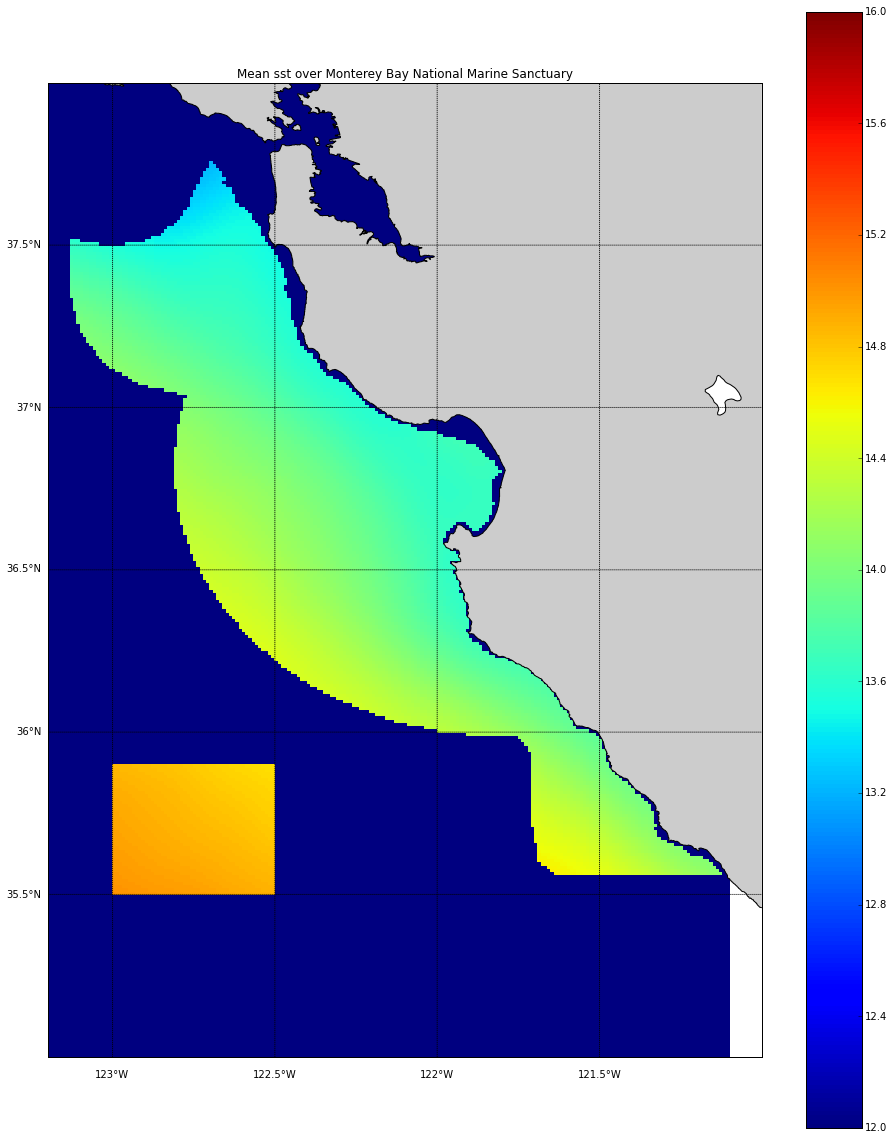

In [36]:
#
plon=360+plon
# draw coastline and fill in the continents
mp.fillcontinents()
mp.drawcoastlines()
zmap2=mp.pcolormesh(glon,glat,np.squeeze(mysum_mbnms),hold=True)
if var=='sst':
    plt.clim(12,16)
zmap=mp.pcolormesh(plon,plat,np.squeeze(mysumarea))
#plt.hold('True')
ll=mysum_mbnms <=0
mysum_mbnms[ll]=np.nan
l2=mysumarea <=0
mysumarea[l2]=np.nan
llat=np.arange(35.5,38,0.5)
llon=np.arange(237,239,0.5)
ax1=mp.drawmeridians(llon,labels=[1,0,0,1])
ax2=mp.drawparallels(llat,labels=[1,0,0,1])
plt.colorbar()
if var=='sst':
    plt.clim(12,16)
tstr='Mean '+var+' over Monterey Bay National Marine Sanctuary'
plt.title(tstr)

In [37]:
plt.clf()

Set up to plot the mean timeseries.

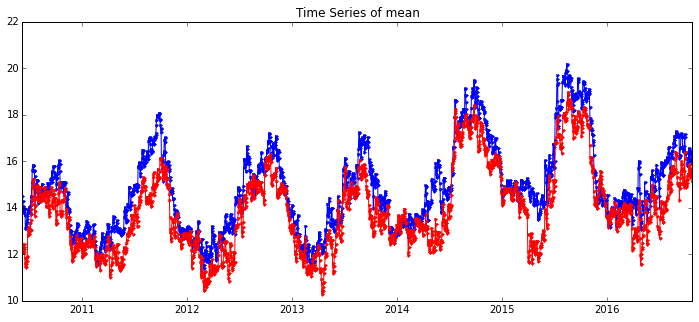

In [38]:
import matplotlib
ptime=[]
for j in mytvec:
    t=datetime.date.fromordinal(int(j))
    ptime=np.append(ptime,t)
dates=matplotlib.dates.date2num(ptime)
plt.rcParams['figure.figsize']=[12,5]
plt.plot_date(dates,mytimeseries,'.-')
plt.plot_date(dates,mybigts,'r.-')
plt.title('Time Series of mean')

So the mean anomay for the data set is 0, thus we need to compute something else.  So lets compute the 
linear regression at each pixel and see what the slopes look like?

In [39]:
from scipy import stats

In [40]:
# set up blank arrays
grad1=np.zeros(mysum_mbnms.shape)
grad2=np.zeros(mysumarea.shape)
inter1=np.zeros(mysum_mbnms.shape)
inter2=np.zeros(mysumarea.shape)
loopa1=np.arange(grad1.shape[0])
loopa2=np.arange(grad1.shape[1])
loopb1=np.arange(grad2.shape[0])
loopb2=np.arange(grad2.shape[1])

Now to loop through the pixels for each area and compute a linear regression at that pixel.

In [41]:
for ip1 in loopa1:
    for ip2 in loopa2:
        grad1[ip1,ip2],inter1[ip1,ip2],r_val,p_val,std_err=stats.linregress(mytvec,mybigarray[:,ip1,ip2])
for ip3 in loopb1:
    for ip4 in loopb2:
        grad2[ip3,ip4],inter1[ip3,ip4],r_val,p_val,std_err=stats.linregress(mytvec,myotherbigarray[:,ip3,ip4])
        

Now we ant to blank data that is outside of the region of interest.

In [42]:
grad1[ll]=np.nan

C:\Anaconda\lib\site-packages\matplotlib\colors.py:584: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


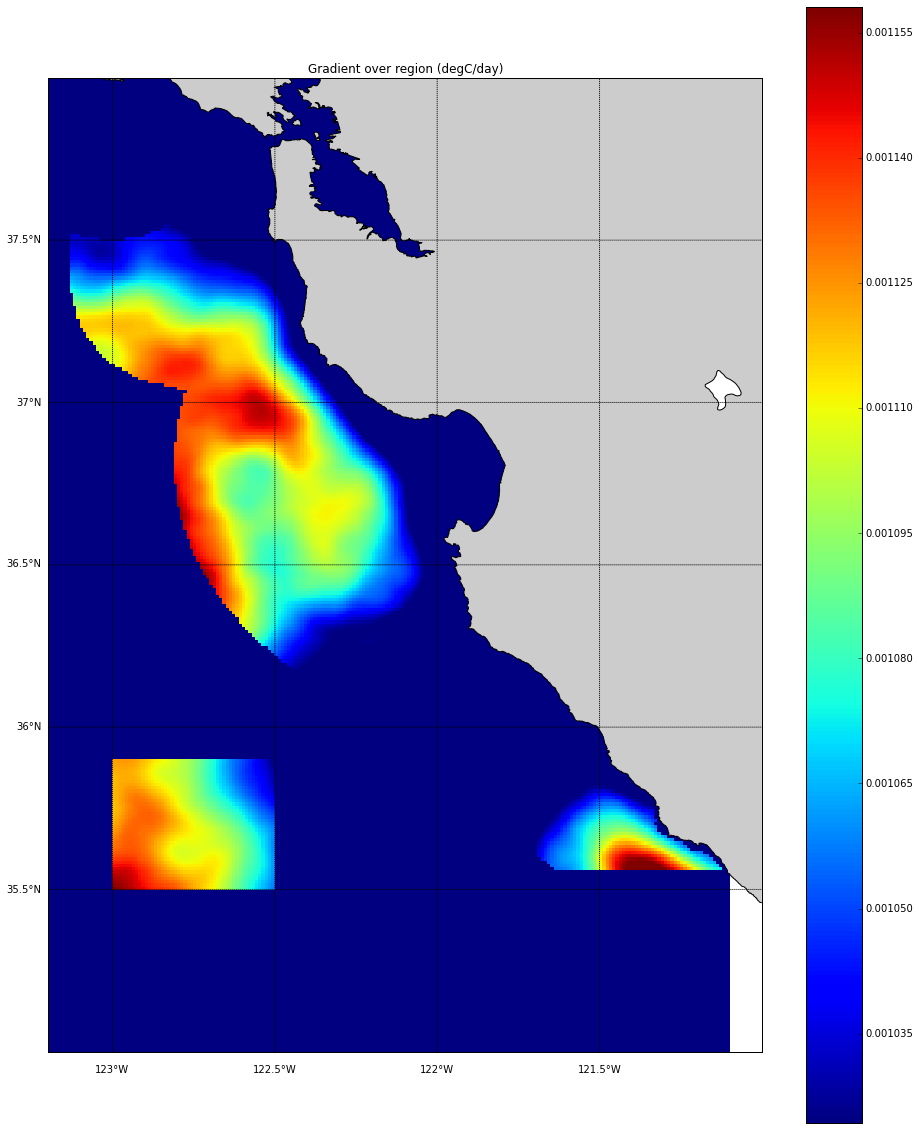

In [43]:
plt.rcParams['figure.figsize']=[16,20]
mp.fillcontinents()
mp.drawcoastlines()
zmap2=mp.pcolormesh(glon,glat,np.squeeze(grad1),hold=True)
if var=='sst':
    plt.clim(0.001,0.0011)
zmap=mp.pcolormesh(plon,plat,np.squeeze(grad2))
plt.hold('True')
llat=np.arange(35.5,38,0.5)
llon=np.arange(237,239,0.5)
ax1=mp.drawmeridians(llon,labels=[1,0,0,1])
ax2=mp.drawparallels(llat,labels=[1,0,0,1])
plt.colorbar()
plt.title('Gradient over region (degC/day)')

In [44]:
gradt1,intercept1,rval,pval,stderr=stats.linregress(mytvec,mytimeseries)
gradt2,intercept2,rval,pval,stderr=stats.linregress(mytvec,mybigts)
newt1=gradt1*mytvec+intercept1
newt2=gradt2*mytvec+intercept2

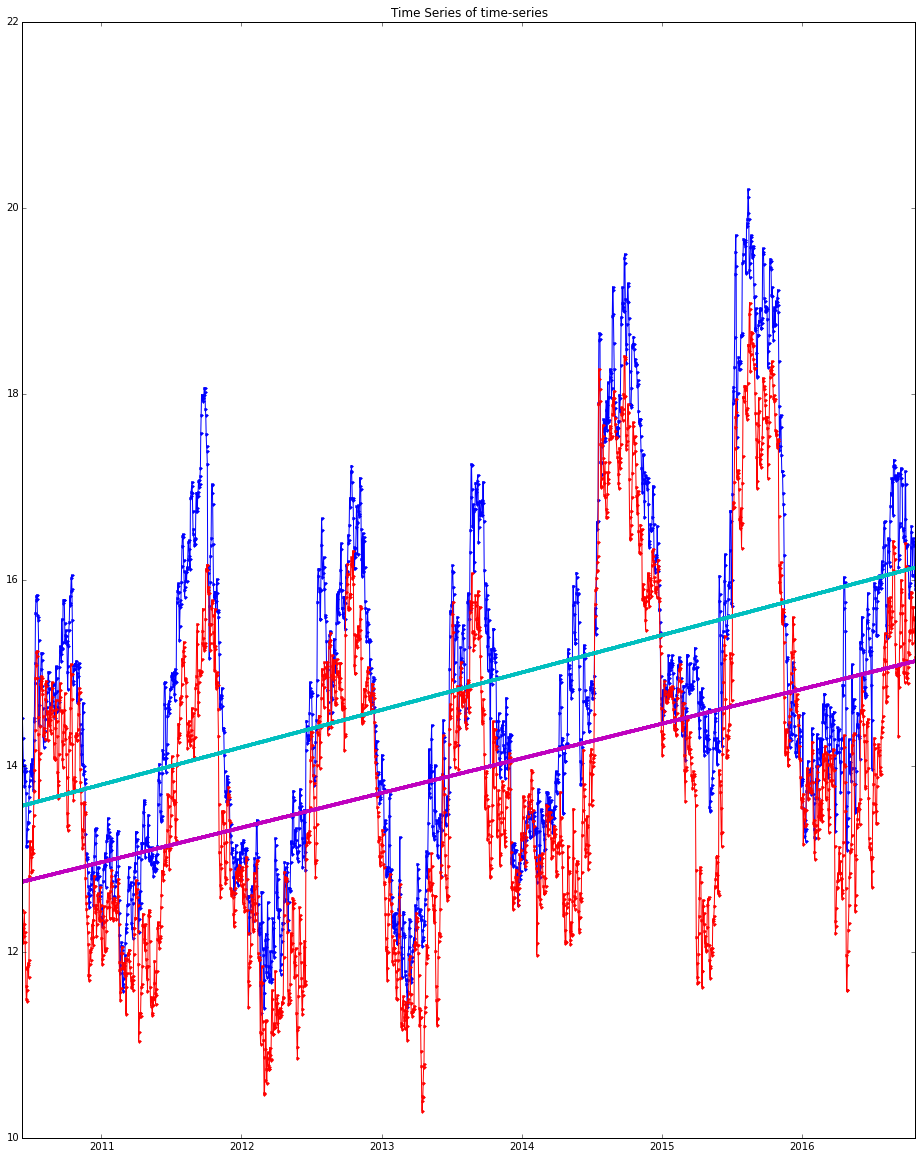

In [45]:
plt.clf()
plt.rcParams['figure.figsize']=[10,5]
plt.plot_date(dates,mytimeseries,'b.-')
plt.plot_date(dates,mybigts,'r.-')
plt.plot_date(dates,newt1,'c.-')
plt.plot_date(dates,newt2,'m.-')
plt.title('Time Series of time-series')

Display the actual value for both the MBNMS and Davidson seamount.

In [46]:
gradt1

0.0011000327917649153

In [47]:
gradt2

0.0010191625576334014

Now to compute anomalies over each region.

In [48]:
[i,j,k]=mybigarray.shape
[l,m,n]=myotherbigarray.shape

Create the yearday so we can compute the daily seasonal value.

In [49]:
idz=np.arange(0,i)
yearday=[]
for ij in idz:
    d=datetime.datetime.fromordinal(int(dates[ij]))
    yd=d.timetuple().tm_yday
    if ij==0:
        yearday=np.array(yd)
    else:
        yearday=np.append(yearday,yd)

Now actually compute the seasonal means.

In [50]:
idy=np.arange(1,367)
season1=np.zeros((366,j,k))
season2=np.zeros((366,m,n))
for jd in idy:
    ijd=np.where(yearday==jd)
    #print ijd
    #print mybigarray.shape
    #xxx=mybigarray[ijd,:,:]
    #print xxx.shape
    season1[jd-1,:,:]=np.mean(np.squeeze(mybigarray[ijd,:,:]),axis=0)
    season2[jd-1,:,:]=np.mean(np.squeeze(myotherbigarray[ijd,:,:]),axis=0)
#print season1.shape
#print season2.shape
#plt.plot(idy,season1[:,0,0])
#plt.plot(idy,season2[:,0,0])

Now to compute a seasonal anomaly.

In [58]:
myanombig=[]
myanomsmall=[]
myanomt1=[]
myanomt2=[]
nc=0
# find non nan data for mask
ll=np.logical_not(np.isnan(mysum_mbnms))
mm=np.arange(0,i)
for n in mm:
    indexyd=yearday[n]
    tmp1=np.squeeze(mybigarray[n,:,:])
    tmp2=np.squeeze(myotherbigarray[n,:,:])
    # find seasonal mean for that day
    tmp3=np.squeeze(season1[indexyd-1,:,:])
    tmp4=np.squeeze(season2[indexyd-1,:,:])
    if n==0:
        # set up first part of the anomaly
        myanombig=np.array(tmp1-tmp3)
#        myanombig=tmp1-tmp3
        myanomsmall=np.array(tmp2-tmp4)
        myanombig=np.expand_dims(myanombig,axis=0)
        myanomsmall=np.expand_dims(myanomsmall,axis=0)
#        myanomsmall=tmp2-tmp4
#        myanombig=tmp1-mysum_mbnms
#        myanomsmall=tmp2-mysumarea
        myanomt1=np.array([np.mean(myanombig[0][ll])])
        myanomt2=np.array([np.mean(myanomsmall[0,:,:])])
        nc=nc+1
    else:
        anom1=tmp1-tmp3
        anom2=tmp2-tmp4
        anom1=np.expand_dims(anom1,axis=0)
        anom2=np.expand_dims(anom2,axis=0)
        myanombig=np.vstack((myanombig,anom1))
#        myanombig=np.append(myanombig,anom1)
        myanomsmall=np.vstack((myanomsmall,anom2))
#        myanomsmall=np.append(myanomsmall,anom2)
        del anom1
        del anom2
#        myanombig=myanombig+(tmp1-tmp3)
        #myanombig=myanombig+(tmp1-mysum_mbnms)
#        myanomsmall=myanomsmall+(tmp2-tmp4)
        #myanomsmall=myanomsmall+(tmp2-mysumarea)
        atmp1=tmp1-tmp3
        #atmp1=tmp1-mysum_mbnms
        atmp2=tmp2-tmp4
        #atmp2=tmp2-mysumarea
        xa1=np.array([np.mean(atmp1[ll])])
        xa2=np.array([np.mean(atmp2)])
        myanomt1=np.append(myanomt1,xa1)
        myanomt2=np.append(myanomt2,xa2)
        nc=nc+1
#myanombig=myanombig/nc
#myanomsmall=myanomsmall/nc

In [53]:
plt.rcParams['figure.figsize']=[16,20]

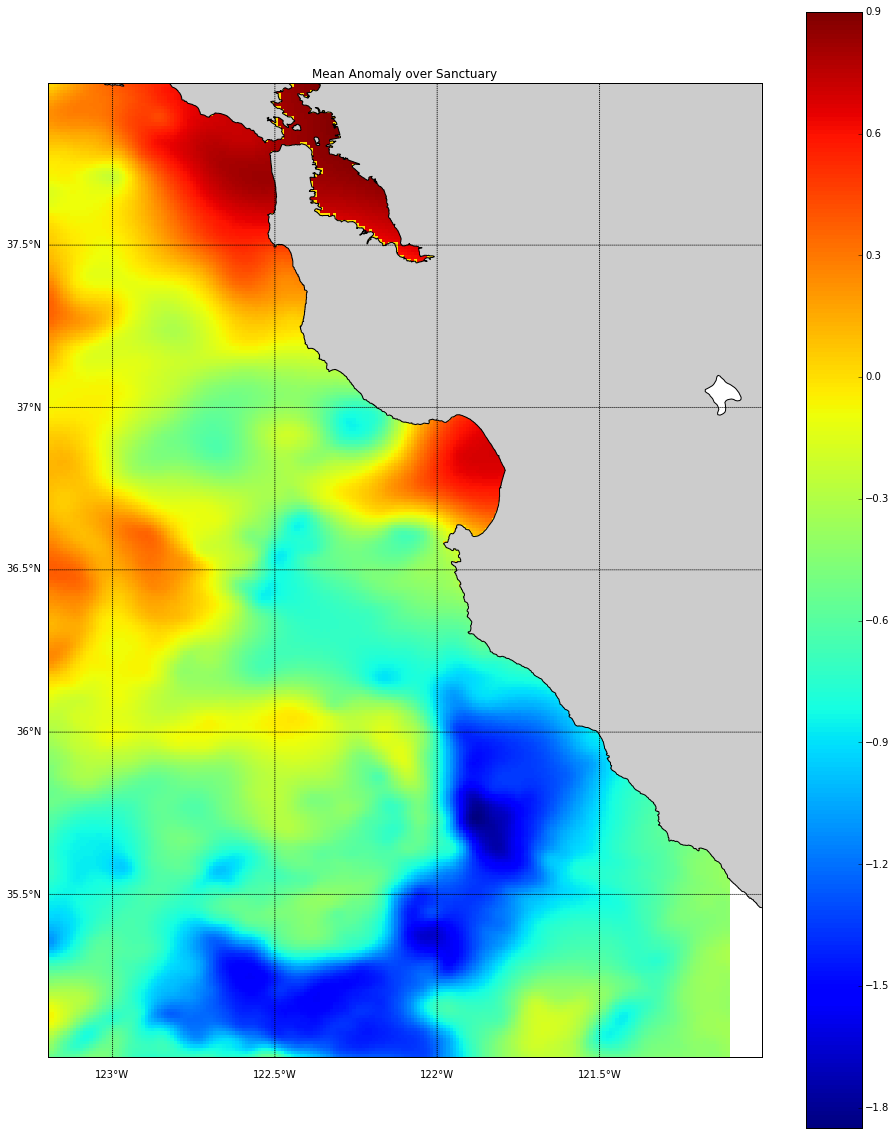

In [61]:
mp.fillcontinents()
mp.drawcoastlines()
zmap2=mp.pcolormesh(glon,glat,np.squeeze(myanombig[-1,:,:]),hold=True)
#zmap=mp.pcolormesh(plon,plat,np.squeeze(myanomsmall))
plt.hold('True')
#l=mysum_mbnms <=0
#mysum_mbnms[ll]=np.nan
llat=np.arange(35.5,38,0.5)
llon=np.arange(237,239,0.5)
ax1=mp.drawmeridians(llon,labels=[1,0,0,1])
ax2=mp.drawparallels(llat,labels=[1,0,0,1])
plt.colorbar()
plt.title('Mean Anomaly over Sanctuary')

In [62]:
ll=np.isnan(myanombig)==0
myanombig[ll]

array([-12.75342857, -12.74571429, -12.73742857, ...,   0.        ,
         0.        ,   0.        ])

In [ ]:
plt.clf()

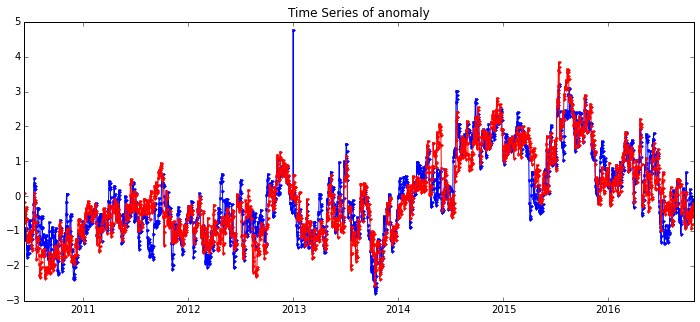

In [63]:
ptime=[]
plt.rcParams['figure.figsize']=[12,5]
plt.plot_date(dates,myanomt1,'.-')
plt.plot_date(dates,myanomt2,'r.-')
plt.title('Time Series of anomaly')

In [64]:
np.mean(myanomt1)

0.0020522689348954639

In [65]:
np.mean(myanomt2)

-4.8855538341906331e-17